#**MODELO OPTIMIZACION RUTA DE MADRID**
El presente modelo se ha diseñado para optimizar de las rutas generadas en Goggle Maps a traves de los datos de tráfico del ayuntamiento de Madrid, 4200 puntos de medida de carga del tráfico

#0.Inizicalización

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importación de librerías
import os
import numpy as np # algebra lineal
import pandas as pd # procesamiento de datos
import matplotlib.pyplot as plt # visualizacion
from PIL import  Image
%matplotlib inline
import seaborn as sns # visualizacion
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py # visualizacion
py.init_notebook_mode(connected=True) 
import plotly.graph_objs as go
import plotly.subplots as sb
import plotly.figure_factory as ff

#1.MODELO TRAFICO
Se genera un primer modelo para predecir la carga de trafico de las calles por donde se genere la ruta.

La **Carga** la variable objetivo y representa la Carga de vehículos en el periodo de 15 minutos. Parámetro que tiene en cuenta intensidad, ocupación y capacidad de la vía y establece el grado de uso de la vía de 0 a 100.

# 1.1.Datos

In [ ]:
#%% Carga del dataframe.
df_trafico = pd.read_csv('/content/drive/MyDrive/PSIA-proyecto-Madrid/modelo_opti_trafico/prototabla_horas.csv',';')
#eliminacion variables no explicativas del modelo
df_trafico = df_trafico.drop(['intensidad'],axis=1)
# La función head de pandas nos sirve para imprimir por pantalla las primeras filas del dataframe
df_trafico.head(3)

,id,fecha_ok,hora_ok,carga,DIA_OK,Semana_mes,latitud,longitud,LLUVIA
0,5257,2019-01-30,08:30,18,miercoles,5,40.363658,-3.763558,"3,29"
1,5257,2019-01-30,08:45,20,miercoles,5,40.363658,-3.763558,"3,29"
2,5257,2019-01-30,09:00,24,miercoles,5,40.363658,-3.763558,"3,29"


**Descripcion de variables:**

*   **id** = Identificador del Punto de Medida en los Sistemas de Tráfico
*   **latitud** = Coordenada geografica del punto de medida.
*   **longitud** = Coordenada geografica del punto de medida.
*   **fecha_ok** = Fecha toma de la medida con formato yyyy-mm-dd.
*   **hora_ok** = Hora toma de la medida con formato hh:mi.
*   **carga** = Carga de vehículos en el periodo de 15 minutos. Parámetro que tiene en cuenta intensidad, ocupación y capacidad de la vía y establece el grado de uso de la vía de 0 a 100.
*   **LLUVIA** = PRECIPITACIÓN litros/m2

In [ ]:
print ("Nº Filas     : " ,df_trafico.shape[0])
print ("Nº Columnas  : " ,df_trafico.shape[1])
print ("\nCampos : \n" ,df_trafico.columns.tolist())
print ("\nValores ausentes :  ", df_trafico.isnull().sum().values.sum())
print ("\nValores únicos :  \n",df_trafico.nunique())
print ("\nValores:   \n",df_trafico.count()) 
df_trafico.dtypes

Nº Filas     :  6946818
Nº Columnas  :  9

Campos : 
 ['id', 'fecha_ok', 'hora_ok', 'carga', 'DIA_OK', 'Semana_mes', 'latitud', 'longitud', 'LLUVIA']

Valores ausentes :   456

Valores únicos :  
 id            4085
fecha_ok       365
hora_ok          5
carga          101
DIA_OK           8
Semana_mes       6
latitud       4349
longitud      4349
LLUVIA          87
dtype: int64

Valores:   
 id            6946818
fecha_ok      6946818
hora_ok       6946818
carga         6946818
DIA_OK        6946818
Semana_mes    6946818
latitud       6946590
longitud      6946590
LLUVIA        6946818
dtype: int64


id              int64
fecha_ok       object
hora_ok        object
carga           int64
DIA_OK         object
Semana_mes      int64
latitud       float64
longitud      float64
LLUVIA         object
dtype: object

#1.2.Manipulacion Datos

In [ ]:
# Procesamiento de datos
## Reemplazo de comas por puntos (hecho al cargar datframe)
df_trafico["LLUVIA"] = df_trafico["LLUVIA"].str.replace(",", ".").astype(float)
df_trafico["id"] = df_trafico["id"].astype(object)


In [ ]:
# Procesamiento de datos

## Reemplazo de 'domingo' por 'festivo' y separacion Dataframe Fin de Semana
df_trafico["DIA_OK"]= df_trafico["DIA_OK"].replace({'domingo' : 'festivo'})
df_trafico["DIA_OK"]= df_trafico["DIA_OK"].replace({'sabado':'festivo'})
finde_df=df_trafico['DIA_OK']=='festivo'
df_trafico = df_trafico.drop(df_trafico[df_trafico['DIA_OK']=='festivo'].index)

## Eliminación de registros con valores nulos
df_trafico = df_trafico.dropna() 
df_trafico = df_trafico[df_trafico["latitud"].notnull()]
df_trafico = df_trafico.reset_index()[df_trafico.columns]
df_trafico = df_trafico[df_trafico["longitud"].notnull()]
df_trafico = df_trafico.reset_index()[df_trafico.columns]

print ("\nValores ausentes :  ", df_trafico.isnull().sum().values.sum())
print ("Nº Filas     : " ,df_trafico.shape[0])
df_trafico.count()


Valores ausentes :   0
Nº Filas     :  4707877


id            4707877
fecha_ok      4707877
hora_ok       4707877
carga         4707877
DIA_OK        4707877
Semana_mes    4707877
latitud       4707877
longitud      4707877
LLUVIA        4707877
dtype: int64

In [ ]:
##obtencion columna mes
df_trafico["fecha_ok"]=pd.to_datetime(df_trafico["fecha_ok"])
df_trafico["mes"] = df_trafico["fecha_ok"].dt.month

print ("Dim matriz     : " ,df_trafico.shape)
df_trafico.head()

Dim matriz     :  (4707877, 10)


,id,fecha_ok,hora_ok,carga,DIA_OK,Semana_mes,latitud,longitud,LLUVIA,mes
0,5257,2019-01-30,08:30,18,miercoles,5,40.363658,-3.763558,3.29,1
1,5257,2019-01-30,08:45,20,miercoles,5,40.363658,-3.763558,3.29,1
2,5257,2019-01-30,09:00,24,miercoles,5,40.363658,-3.763558,3.29,1
3,5257,2019-01-30,09:15,27,miercoles,5,40.363658,-3.763558,3.29,1
4,5257,2019-01-30,09:30,13,miercoles,5,40.363658,-3.763558,3.29,1


In [ ]:
#Categorización/discretización tipo de via
def carga_lab(df_trafico) :
    
    if df_trafico["carga"] <= 25 :
        return "carga_baja"
    elif (df_trafico["carga"] > 25) & (df_trafico["carga"] <= 50 ):
        return "carga_media"
    elif (df_trafico["carga"] > 50) & (df_trafico["carga"] <= 75) :
        return "carga_alta"
    elif df_trafico["carga"] > 75 :
        return "carga_muy_alta"
df_trafico["tipo_via"] = df_trafico.apply(lambda df_trafico:carga_lab(df_trafico),
                                      axis = 1)
df_trafico.loc[:,'tipo_via']

0           carga_baja
1           carga_baja
2           carga_baja
3          carga_media
4           carga_baja
              ...     
4707872     carga_baja
4707873     carga_baja
4707874     carga_baja
4707875     carga_baja
4707876     carga_baja
Name: tipo_via, Length: 4707877, dtype: object

In [ ]:
print(df_trafico.dtypes)
print(df_trafico.count())
df_trafico.head()

id                    object
fecha_ok      datetime64[ns]
hora_ok               object
carga                  int64
DIA_OK                object
Semana_mes             int64
latitud              float64
longitud             float64
LLUVIA               float64
mes                    int64
tipo_via              object
dtype: object
id            4707877
fecha_ok      4707877
hora_ok       4707877
carga         4707877
DIA_OK        4707877
Semana_mes    4707877
latitud       4707877
longitud      4707877
LLUVIA        4707877
mes           4707877
tipo_via      4707877
dtype: int64


,id,fecha_ok,hora_ok,carga,DIA_OK,Semana_mes,latitud,longitud,LLUVIA,mes,tipo_via
0,5257,2019-01-30,08:30,18,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja
1,5257,2019-01-30,08:45,20,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja
2,5257,2019-01-30,09:00,24,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja
3,5257,2019-01-30,09:15,27,miercoles,5,40.363658,-3.763558,3.29,1,carga_media
4,5257,2019-01-30,09:30,13,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja


In [ ]:
#Se extrae la tabla de trafico
#df_trafico.to_csv('dataframetrafico.csv')

#1.3.Análisis exploratorio de datos

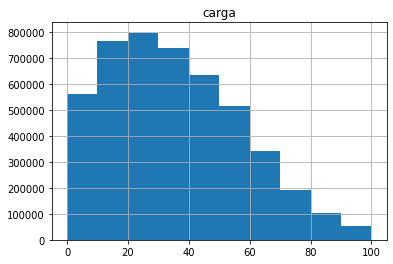

In [ ]:
my_plot = df_trafico.hist("carga")


In [ ]:
#Resumen de los datos
summary = (df_trafico[[i for i in df_trafico.columns]].
           describe().transpose().reset_index())
summary = summary.rename(columns = {"index" : "variable"})
summary = np.around(summary,3)
summary.head()

,variable,count,mean,std,min,25%,50%,75%,max
0,carga,4707877.0,34.943,21.837,0.000,18.000,32.000,50.000,100.000
1,Semana_mes,4707877.0,3.144,1.280,1.000,2.000,3.000,4.000,5.000
2,latitud,4707877.0,40.430,0.037,40.332,40.399,40.431,40.459,40.516
3,longitud,4707877.0,-3.688,0.040,-3.837,-3.713,-3.691,-3.663,-3.581
4,LLUVIA,4707877.0,0.988,3.751,0.000,0.000,0.000,0.080,31.730


In [ ]:
val_lst = [summary['variable'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Resumen estadístico de los datos"))
figure = go.Figure(data=[trace],layout=layout)
figure.show(renderer="colab")

#1.4.Pre-Procesamiento de Datos

In [ ]:
# Copia dataframe
df_trafico_orig=df_trafico.copy()

#eliminacion variables fecha ya descompuesta
df_trafico =df_trafico.drop(columns=["fecha_ok"])

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# Columna ID
id_col     = ['id']
# Variable target
target_col = ["carga"]
# Variables categóricas
cat_cols   = df_trafico.nunique()[df_trafico.nunique() < 9].keys().tolist()
# Variables numéricas
num_cols   = [x for x in df_trafico.columns if x not in cat_cols if x not in target_col]
# Variables cualitativas multiclase (más de dos valores)
multi_cols = [i for i in cat_cols]

print('Columna Ident:',id_col)
print('columna Target:',target_col)
print('Columnas Categorica:',cat_cols)
print('Columnas numericas:',num_cols)
print('Columnas multiclase:',multi_cols)

Columna Ident: ['id']
columna Target: ['carga']
Columnas Categorica: ['hora_ok', 'DIA_OK', 'Semana_mes', 'tipo_via']
Columnas numericas: ['id', 'latitud', 'longitud', 'LLUVIA', 'mes']
Columnas multiclase: ['hora_ok', 'DIA_OK', 'Semana_mes', 'tipo_via']


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# One-hot encoding para las variables categóricas multiclase 
df_trafico = pd.get_dummies(data = df_trafico,columns = multi_cols )

df_trafico.head()

,id,carga,latitud,longitud,LLUVIA,mes,hora_ok_08:30,hora_ok_08:45,hora_ok_09:00,hora_ok_09:15,hora_ok_09:30,DIA_OK_jueves,DIA_OK_lunes,DIA_OK_martes,DIA_OK_miercoles,DIA_OK_viernes,Semana_mes_1,Semana_mes_2,Semana_mes_3,Semana_mes_4,Semana_mes_5,tipo_via_carga_alta,tipo_via_carga_baja,tipo_via_carga_media,tipo_via_carga_muy_alta
0,5257,18,40.363658,-3.763558,3.29,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
1,5257,20,40.363658,-3.763558,3.29,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,5257,24,40.363658,-3.763558,3.29,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,5257,27,40.363658,-3.763558,3.29,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
4,5257,13,40.363658,-3.763558,3.29,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0


#1.5.Modelo

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [ ]:
# Split del dataset en train y test
train, test = train_test_split(df_trafico,test_size = .2,random_state = 111)
    
# Separación de inputs y output(variables explicativas o independientes) y output (variable de respuesta o dependiente)
## Sinónimos: input  = variable idependiente = variable predictora = variable explicativa
##            output = variable dependiente  = variable predicha   = variable de respuesta/target
cols    = [i for i in df_trafico.columns if i not in id_col + target_col]
train_X1 = train[cols]
train_Y1 = train[target_col]
test_X1  = test[cols]
test_Y1  = test[target_col]
print('train_X1:',train_X1.shape)
print('train_Y1:',train_Y1.shape)
print('test_X1:',test_X1.shape)
print('test_Y1:',test_Y1.shape)

train_X1: (3766301, 23)
train_Y1: (3766301, 1)
test_X1: (941576, 23)
test_Y1: (941576, 1)


In [ ]:
#Modelo gradient Boosting regresor
reg1 = ensemble.GradientBoostingRegressor(random_state = 111)
reg1 = reg1.fit(train_X1, train_Y1)
print('Modelo gradient Boosting regresor  R2=',reg1.score(test_X1, test_Y1))

Modelo gradient Boosting regresor  R2= 0.9009444198399946


In [ ]:
#Modelo arbol
from sklearn import tree
arbol1=tree.DecisionTreeRegressor()
arbol1=arbol1.fit(train_X1,train_Y1)
print('Modelo arbol  R2=',arbol1.score(test_X1,test_Y1))

Modelo arbol  R2= 0.9461335954744632


#2.MODELO MEJORADO CON CLUSTERIZACION

#2.1. Correlacionamos puntos de medida con clusters ya creados

In [ ]:
#%% Carga del dataframe.
df_clusters= pd.read_csv('/content/drive/MyDrive/PSIA-proyecto-Madrid/modelo_cluster_final/clusterptosmedida.csv')

# La función head de pandas nos sirve para imprimir por pantalla las primeras filas del dataframe
print(df_clusters.columns)
df_clusters.head()

Index(['Unnamed: 0', 'id', 'longitud', 'latitud', 'cluster'], dtype='object')


,Unnamed: 0,id,longitud,latitud,cluster
0,0,3840,-3.688323,40.430502,143
1,1,3841,-3.687256,40.430524,143
2,2,3842,-3.691727,40.422132,283
3,3,3843,-3.691929,40.421433,52
4,4,3844,-3.688470,40.433782,197


In [ ]:
#se eliminan las columnas que no vamos a utilizar
df_clusters = df_clusters.drop(columns = ['longitud'],axis = 1)
df_clusters = df_clusters.drop(columns = ['latitud'],axis = 1)
df_clusters = df_clusters.drop(columns = ['Unnamed: 0'],axis = 1)
print(df_clusters.dtypes)

id         int64
cluster    int64
dtype: object


In [ ]:
#Convertimos los campos a categoricos
df_clusters["id"] = df_clusters["id"].astype(object)

print(df_clusters.dtypes)
df_trafico_orig.dtypes

id         object
cluster     int64
dtype: object


id                    object
fecha_ok      datetime64[ns]
hora_ok               object
carga                  int64
DIA_OK                object
Semana_mes             int64
latitud              float64
longitud             float64
LLUVIA               float64
mes                    int64
tipo_via              object
dtype: object

In [ ]:
#asignamos a cada pto de medida su cluster asociado
df_trafico_cluster=pd.merge(df_trafico_orig,df_clusters,on='id',how='left')
print(df_trafico_cluster.shape)
print ("\nValores ausentes :  ", df_trafico_cluster.isnull().sum().values.sum())
df_trafico_cluster.head()

(4707877, 12)

Valores ausentes :   6964


,id,fecha_ok,hora_ok,carga,DIA_OK,Semana_mes,latitud,longitud,LLUVIA,mes,tipo_via,cluster
0,5257,2019-01-30,08:30,18,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja,35.0
1,5257,2019-01-30,08:45,20,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja,35.0
2,5257,2019-01-30,09:00,24,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja,35.0
3,5257,2019-01-30,09:15,27,miercoles,5,40.363658,-3.763558,3.29,1,carga_media,35.0
4,5257,2019-01-30,09:30,13,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja,35.0


In [ ]:
## Eliminación de registros con valores nulos en el campo cluster 
df_trafico_cluster = df_trafico_cluster[df_trafico_cluster["cluster"].notnull()]
df_trafico_cluster = df_trafico_cluster.reset_index()[df_trafico_cluster.columns]
print ("\nValores ausentes :  ", df_trafico_cluster.isnull().sum().values.sum())


Valores ausentes :   0


In [ ]:
#calculo de la carga del cluster por fecha y hora
sumarize_cluster = df_trafico_cluster.groupby(['cluster','fecha_ok','hora_ok']).mean().reset_index()
sumarize_cluster

,cluster,fecha_ok,hora_ok,carga,Semana_mes,latitud,longitud,LLUVIA,mes
0,0.0,2019-01-08,08:30,39.272727,2.0,40.388573,-3.644235,0.0,1.0
1,0.0,2019-01-08,08:45,41.272727,2.0,40.388573,-3.644235,0.0,1.0
2,0.0,2019-01-08,09:00,45.090909,2.0,40.388573,-3.644235,0.0,1.0
3,0.0,2019-01-08,09:15,45.909091,2.0,40.388573,-3.644235,0.0,1.0
4,0.0,2019-01-08,09:30,46.727273,2.0,40.388573,-3.644235,0.0,1.0
...,...,...,...,...,...,...,...,...,...
368606,299.0,2019-12-31,08:30,2.166667,5.0,40.423055,-3.637281,0.0,12.0
368607,299.0,2019-12-31,08:45,3.666667,5.0,40.423055,-3.637281,0.0,12.0
368608,299.0,2019-12-31,09:00,3.333333,5.0,40.423055,-3.637281,0.0,12.0
368609,299.0,2019-12-31,09:15,4.333333,5.0,40.423055,-3.637281,0.0,12.0


In [ ]:
#creacion variables de carga por cluster
sumarize_cluster['carga_cluster']=sumarize_cluster['carga']
#eliminacion columnas no necesarias
sumarize_cluster=sumarize_cluster.drop(['Semana_mes','latitud','longitud','LLUVIA','mes', 'carga'], axis=1)
sumarize_cluster.head(10)

,cluster,fecha_ok,hora_ok,carga_cluster
0,0.0,2019-01-08,08:30,39.272727
1,0.0,2019-01-08,08:45,41.272727
2,0.0,2019-01-08,09:00,45.090909
3,0.0,2019-01-08,09:15,45.909091
4,0.0,2019-01-08,09:30,46.727273
5,0.0,2019-01-09,08:30,43.363636
6,0.0,2019-01-09,08:45,40.909091
7,0.0,2019-01-09,09:00,46.090909
8,0.0,2019-01-09,09:15,48.090909
9,0.0,2019-01-09,09:30,47.181818


In [ ]:
#union dataframe con carga del cluster
df_trafico_completo=df_trafico_cluster
df_trafico_completo=df_trafico_cluster.merge(sumarize_cluster, on=['cluster','fecha_ok','hora_ok'],how='left')
df_trafico_completo.head()

,id,fecha_ok,hora_ok,carga,DIA_OK,Semana_mes,latitud,longitud,LLUVIA,mes,tipo_via,cluster,carga_cluster
0,5257,2019-01-30,08:30,18,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja,35.0,16.222222
1,5257,2019-01-30,08:45,20,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja,35.0,20.777778
2,5257,2019-01-30,09:00,24,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja,35.0,24.000000
3,5257,2019-01-30,09:15,27,miercoles,5,40.363658,-3.763558,3.29,1,carga_media,35.0,16.111111
4,5257,2019-01-30,09:30,13,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja,35.0,12.555556


#2.2 Analisis exploratorio de datos

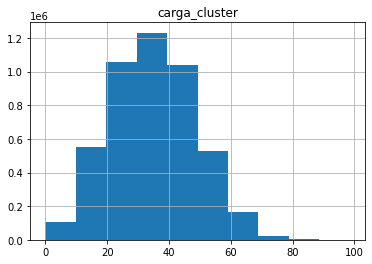

In [ ]:
my_plot = df_trafico_completo.hist("carga_cluster")

In [ ]:
#Resumen de los datos
summary2 = (df_trafico_completo[[i for i in df_trafico_completo.columns]].
           describe().transpose().reset_index())
summary2 = np.around(summary,3)
summary2.head(25)

,variable,count,mean,std,min,25%,50%,75%,max
0,carga,4707877.0,34.943,21.837,0.000,18.000,32.000,50.000,100.000
1,Semana_mes,4707877.0,3.144,1.280,1.000,2.000,3.000,4.000,5.000
2,latitud,4707877.0,40.430,0.037,40.332,40.399,40.431,40.459,40.516
3,longitud,4707877.0,-3.688,0.040,-3.837,-3.713,-3.691,-3.663,-3.581
4,LLUVIA,4707877.0,0.988,3.751,0.000,0.000,0.000,0.080,31.730
5,mes,4707877.0,6.619,3.397,1.000,4.000,7.000,10.000,12.000


In [ ]:
summary2 = (df_trafico_completo[[i for i in df_trafico_completo.columns if i not in id_col]].
           describe().transpose().reset_index())

summary2 = summary2.rename(columns = {"index" : "variable"})
summary2 = np.around(summary2,3)

val_lst = [summary2['variable'], summary2['count'],
           summary2['mean'],summary2['std'],
           summary2['min'], summary2['25%'],
           summary2['50%'], summary2['75%'], summary2['max']]

trace  = go.Table(header = dict(values = summary2.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Resumen estadístico de los datos"))
figure = go.Figure(data=[trace],layout=layout)
figure.show(renderer="colab")


#2.3.Pre-Procesamiento de Datos

In [ ]:
# Copia dataframe
df_trafico_orig2=df_trafico_completo.copy()
#eliminacion variables no relacionales modelo
df_trafico_completo=df_trafico_completo.drop(['fecha_ok',], axis=1)
print(df_trafico_completo.dtypes)

id                object
hora_ok           object
carga              int64
DIA_OK            object
Semana_mes         int64
latitud          float64
longitud         float64
LLUVIA           float64
mes                int64
tipo_via          object
cluster          float64
carga_cluster    float64
dtype: object


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# Columna ID
id_col2     = ['id']
# Variable target
target_col2 = ["carga"]
# Variables categóricas
cat_cols2   = df_trafico_completo.nunique()[df_trafico_completo.nunique() < 6].keys().tolist()
# Variables numéricas
num_cols2   = [x for x in df_trafico_completo.columns if x not in cat_cols2 if x not in target_col2]
# Variables cualitativas multiclase (más de dos valores)
multi_cols2 = [i for i in cat_cols2]

print('Columna Ident:',id_col2)
print('columna Target:',target_col2)
print('Columnas Categorica:',cat_cols2)
print('Columnas numericas:',num_cols2)
print('Columnas multiclase:',multi_cols2)

Columna Ident: ['id']
columna Target: ['carga']
Columnas Categorica: ['hora_ok', 'DIA_OK', 'Semana_mes', 'tipo_via']
Columnas numericas: ['id', 'latitud', 'longitud', 'LLUVIA', 'mes', 'cluster', 'carga_cluster']
Columnas multiclase: ['hora_ok', 'DIA_OK', 'Semana_mes', 'tipo_via']


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
    
# One-hot encoding para las variables categóricas multiclase 
df_trafico_completo = pd.get_dummies(data = df_trafico_completo,columns = multi_cols2 )

df_trafico_completo.head()

,id,carga,latitud,longitud,LLUVIA,mes,cluster,carga_cluster,hora_ok_08:30,hora_ok_08:45,hora_ok_09:00,hora_ok_09:15,hora_ok_09:30,DIA_OK_jueves,DIA_OK_lunes,DIA_OK_martes,DIA_OK_miercoles,DIA_OK_viernes,Semana_mes_1,Semana_mes_2,Semana_mes_3,Semana_mes_4,Semana_mes_5,tipo_via_carga_alta,tipo_via_carga_baja,tipo_via_carga_media,tipo_via_carga_muy_alta
0,5257,18,40.363658,-3.763558,3.29,1,35.0,16.222222,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
1,5257,20,40.363658,-3.763558,3.29,1,35.0,20.777778,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,5257,24,40.363658,-3.763558,3.29,1,35.0,24.000000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,5257,27,40.363658,-3.763558,3.29,1,35.0,16.111111,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
4,5257,13,40.363658,-3.763558,3.29,1,35.0,12.555556,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0


#2.4.Modelo mejorado Cluster

In [ ]:
# Split del dataset en train y test
train2, test2 = train_test_split(df_trafico_completo,test_size = .2,random_state = 111)
    
# Separación de inputs y output(variables explicativas o independientes) y output (variable de respuesta o dependiente)
## Sinónimos: input  = variable idependiente = variable predictora = variable explicativa
##            output = variable dependiente  = variable predicha   = variable de respuesta/target
cols2    = [i for i in df_trafico_completo.columns if i not in id_col2 + target_col2]
train2_X = train2[cols2]
train2_Y = train2[target_col2]
test2_X  = test2[cols2]
test2_Y  = test2[target_col2]
print('train2_X:',train2_X.shape)
print('train2_Y:',train2_Y.shape)
print('test2_X:',test2_X.shape)
print('test2_Y:',test2_Y.shape)

train2_X: (3760730, 25)
train2_Y: (3760730, 1)
test2_X: (940183, 25)
test2_Y: (940183, 1)


In [ ]:
train2_X.head()

,latitud,longitud,LLUVIA,mes,cluster,carga_cluster,hora_ok_08:30,hora_ok_08:45,hora_ok_09:00,hora_ok_09:15,hora_ok_09:30,DIA_OK_jueves,DIA_OK_lunes,DIA_OK_martes,DIA_OK_miercoles,DIA_OK_viernes,Semana_mes_1,Semana_mes_2,Semana_mes_3,Semana_mes_4,Semana_mes_5,tipo_via_carga_alta,tipo_via_carga_baja,tipo_via_carga_media,tipo_via_carga_muy_alta
160280,40.457479,-3.690596,0.000000,1,233.0,39.058824,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0
933878,40.475980,-3.674579,0.000000,3,68.0,47.000000,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
2140134,40.333623,-3.714518,0.000000,6,117.0,13.750000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
484714,40.416469,-3.689041,0.000000,2,142.0,45.473684,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
2265988,40.392636,-3.760801,1.711111,7,235.0,17.818182,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0


In [ ]:
#Modelo gradient Boosting regresor
reg = ensemble.GradientBoostingRegressor(random_state = 111)
reg.fit(train2_X, train2_Y)
print('Modelo gradient Boosting regresor mejorado clusterización R2=',reg.score(test2_X, test2_Y))

Modelo gradient Boosting regresor mejorado clusterización R2= 0.9052700658508848


In [ ]:
#Modelo arbol
from sklearn import tree
arbol2=tree.DecisionTreeRegressor()
arbol2=arbol2.fit(train2_X,train2_Y)
print('Modelo arbol mejorado clsuterización R2=',arbol2.score(test2_X,test2_Y))

Modelo arbol mejorado clsuterización R2= 0.9504139020553929


#3.PREDICCIÓN CARGA RUTA

#3.1 Calculo carga clusters en el dia y hora de la ruta

In [ ]:
#copia del data frame original
df_ruta_cluster= df_trafico_orig
df_ruta_cluster.head()

,id,fecha_ok,hora_ok,carga,DIA_OK,Semana_mes,latitud,longitud,LLUVIA,mes,tipo_via
0,5257,2019-01-30,08:30,18,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja
1,5257,2019-01-30,08:45,20,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja
2,5257,2019-01-30,09:00,24,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja
3,5257,2019-01-30,09:15,27,miercoles,5,40.363658,-3.763558,3.29,1,carga_media
4,5257,2019-01-30,09:30,13,miercoles,5,40.363658,-3.763558,3.29,1,carga_baja


In [ ]:
#filtrar tabla para eliminar id repetidos
df_ruta_cluster=df_ruta_cluster.drop_duplicates(subset='id')
print(df_ruta_cluster.count())
print ("\nValores ausentes :  ", df_trafico.isnull().values.any())

id            4081
fecha_ok      4081
hora_ok       4081
carga         4081
DIA_OK        4081
Semana_mes    4081
latitud       4081
longitud      4081
LLUVIA        4081
mes           4081
tipo_via      4081
dtype: int64

Valores ausentes :   False


In [ ]:
#asignamos fecha, dia ,hora y lluvia del dia que queremos predecir la carga de los clusters
df_ruta_cluster["mes"]=3.0
df_ruta_cluster['Semana_mes']=3
df_ruta_cluster['hora_ok']='09:00'
df_ruta_cluster['DIA_OK'] = 'jueves'
df_ruta_cluster['LLUVIA']= 0.0
df_ruta_cluster_or=df_ruta_cluster
print ("\nValores ausentes :  ", df_trafico.isnull().sum().values.sum())
df_ruta_cluster.head()


Valores ausentes :   0


,id,fecha_ok,hora_ok,carga,DIA_OK,Semana_mes,latitud,longitud,LLUVIA,mes,tipo_via
0,5257,2019-01-30,09:00,18,jueves,3,40.363658,-3.763558,0.0,3.0,carga_baja
10,7029,2019-01-10,09:00,29,jueves,3,40.424220,-3.690780,0.0,3.0,carga_media
15,6644,2019-01-16,09:00,88,jueves,3,40.470874,-3.671757,0.0,3.0,carga_muy_alta
26,6288,2019-01-31,09:00,39,jueves,3,40.470742,-3.650827,0.0,3.0,carga_media
31,7024,2019-01-28,09:00,85,jueves,3,40.474534,-3.697941,0.0,3.0,carga_muy_alta


In [ ]:
#Carga del dummy dataframe para poder realizar predicción.
df_dummy = pd.read_csv('/content/drive/MyDrive/PSIA-proyecto-Madrid/modelo_opti_trafico/trafico_dummy.csv',';')

# La función head de pandas nos sirve para imprimir por pantalla las primeras filas del dataframe
df_dummy.head(5)

,id,hora_ok,carga,DIA_OK,Semana_mes,latitud,longitud,LLUVIA,mes,tipo_via
0,1,08:30,0,lunes,1,NaN,NaN,0,1,carga_baja
1,1,08:45,0,martes,2,NaN,NaN,0,1,carga_media
2,1,09:00,0,miercoles,3,NaN,NaN,0,1,carga_alta
3,1,09:15,0,jueves,4,NaN,NaN,0,1,carga_muy_alta
4,1,09:30,0,viernes,5,NaN,NaN,0,1,carga_muy_alta


In [ ]:
#se unen ambos dataframes para poder realizar encoding correctamente
df_ruta_cluster=pd.concat([df_ruta_cluster,df_dummy])
df_ruta_cluster.tail(10)

,id,fecha_ok,hora_ok,carga,DIA_OK,Semana_mes,latitud,longitud,LLUVIA,mes,tipo_via
4698195,10515,2019-12-05,09:00,30,jueves,3,40.451382,-3.772975,0.0,3.0,carga_media
4704056,10526,2019-12-10,09:00,13,jueves,3,40.462583,-3.794009,0.0,3.0,carga_baja
4704254,10528,2019-12-24,09:00,59,jueves,3,40.418099,-3.698909,0.0,3.0,carga_alta
4704292,10529,2019-12-27,09:00,10,jueves,3,40.505407,-3.666390,0.0,3.0,carga_baja
4705796,10524,2019-12-04,09:00,19,jueves,3,40.461953,-3.792382,0.0,3.0,carga_baja
0,1,NaT,08:30,0,lunes,1,NaN,NaN,0.0,1.0,carga_baja
1,1,NaT,08:45,0,martes,2,NaN,NaN,0.0,1.0,carga_media
2,1,NaT,09:00,0,miercoles,3,NaN,NaN,0.0,1.0,carga_alta
3,1,NaT,09:15,0,jueves,4,NaN,NaN,0.0,1.0,carga_muy_alta
4,1,NaT,09:30,0,viernes,5,NaN,NaN,0.0,1.0,carga_muy_alta


In [ ]:
#eliminacion variables no relacionales modelo
df_ruta_cluster = df_ruta_cluster.drop(columns=["fecha_ok"])

In [ ]:
from sklearn.preprocessing import LabelEncoder
    
# One-hot encoding para las variables categóricas multiclase 
df_ruta_cluster = pd.get_dummies(data = df_ruta_cluster,columns = multi_cols )
num_cols3= ['carga', 'latitud', 'longitud', 'LLUVIA', 'mes']
print(num_cols3)
print(df_ruta_cluster.shape)
df_ruta_cluster.head()

['carga', 'latitud', 'longitud', 'LLUVIA', 'mes']
(4086, 25)


,id,carga,latitud,longitud,LLUVIA,mes,hora_ok_08:30,hora_ok_08:45,hora_ok_09:00,hora_ok_09:15,hora_ok_09:30,DIA_OK_jueves,DIA_OK_lunes,DIA_OK_martes,DIA_OK_miercoles,DIA_OK_viernes,Semana_mes_1,Semana_mes_2,Semana_mes_3,Semana_mes_4,Semana_mes_5,tipo_via_carga_alta,tipo_via_carga_baja,tipo_via_carga_media,tipo_via_carga_muy_alta
0,5257,18,40.363658,-3.763558,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
10,7029,29,40.424220,-3.690780,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
15,6644,88,40.470874,-3.671757,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
26,6288,39,40.470742,-3.650827,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
31,7024,85,40.474534,-3.697941,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
## Eliminación de registros del dummy dataframe con valores nulos
df_ruta_cluster = df_ruta_cluster.dropna() 
print ("\nValores ausentes :  ", df_ruta_cluster.isnull().sum().values.sum())
print ("Dim    : " ,df_ruta_cluster.info())
df_ruta_cluster.shape


Valores ausentes :   0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4081 entries, 0 to 4705796
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       4081 non-null   object 
 1   carga                    4081 non-null   int64  
 2   latitud                  4081 non-null   float64
 3   longitud                 4081 non-null   float64
 4   LLUVIA                   4081 non-null   float64
 5   mes                      4081 non-null   float64
 6   hora_ok_08:30            4081 non-null   uint8  
 7   hora_ok_08:45            4081 non-null   uint8  
 8   hora_ok_09:00            4081 non-null   uint8  
 9   hora_ok_09:15            4081 non-null   uint8  
 10  hora_ok_09:30            4081 non-null   uint8  
 11  DIA_OK_jueves            4081 non-null   uint8  
 12  DIA_OK_lunes             4081 non-null   uint8  
 13  DIA_OK_martes            4081 non-null   uint8  
 1

(4081, 25)

In [ ]:
#split del dataset para hacer predicción carga del clusters
Y_ruta=df_ruta_cluster['id']
X_ruta=df_ruta_cluster.drop(['id','carga'],axis=1)
X_ruta.head()

,latitud,longitud,LLUVIA,mes,hora_ok_08:30,hora_ok_08:45,hora_ok_09:00,hora_ok_09:15,hora_ok_09:30,DIA_OK_jueves,DIA_OK_lunes,DIA_OK_martes,DIA_OK_miercoles,DIA_OK_viernes,Semana_mes_1,Semana_mes_2,Semana_mes_3,Semana_mes_4,Semana_mes_5,tipo_via_carga_alta,tipo_via_carga_baja,tipo_via_carga_media,tipo_via_carga_muy_alta
0,40.363658,-3.763558,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
10,40.424220,-3.690780,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
15,40.470874,-3.671757,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
26,40.470742,-3.650827,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
31,40.474534,-3.697941,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
#Predicción carga en puntos para calculara carga de los clusters
pred_cluster=arbol1.predict(X_ruta)
print(pred_cluster.shape)
print(pred_cluster)

(4081,)
[24. 34. 83. ... 51. 14. 25.]


#3.2 Asignacion carga cluster

In [ ]:
df_ruta_cluster.shape

(4081, 25)

In [ ]:
#asignacion de la carga predicha obtenida
df_ruta_cluster['carga']=pred_cluster
df_ruta_cluster.head()

,id,carga,latitud,longitud,LLUVIA,mes,hora_ok_08:30,hora_ok_08:45,hora_ok_09:00,hora_ok_09:15,hora_ok_09:30,DIA_OK_jueves,DIA_OK_lunes,DIA_OK_martes,DIA_OK_miercoles,DIA_OK_viernes,Semana_mes_1,Semana_mes_2,Semana_mes_3,Semana_mes_4,Semana_mes_5,tipo_via_carga_alta,tipo_via_carga_baja,tipo_via_carga_media,tipo_via_carga_muy_alta
0,5257,24.0,40.363658,-3.763558,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
10,7029,34.0,40.424220,-3.690780,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
15,6644,83.0,40.470874,-3.671757,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
26,6288,50.0,40.470742,-3.650827,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
31,7024,83.0,40.474534,-3.697941,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
#asignamos a cada pto de medida su cluster asociado
df_ruta_cluster=pd.merge(df_ruta_cluster,df_clusters,on='id',how='left')
print(df_ruta_cluster.shape)
print("\nValores ausentes : ",df_ruta_cluster.isnull().sum().values.sum())
df_ruta_cluster.head()

(4081, 26)

Valores ausentes :  13


,id,carga,latitud,longitud,LLUVIA,mes,hora_ok_08:30,hora_ok_08:45,hora_ok_09:00,hora_ok_09:15,hora_ok_09:30,DIA_OK_jueves,DIA_OK_lunes,DIA_OK_martes,DIA_OK_miercoles,DIA_OK_viernes,Semana_mes_1,Semana_mes_2,Semana_mes_3,Semana_mes_4,Semana_mes_5,tipo_via_carga_alta,tipo_via_carga_baja,tipo_via_carga_media,tipo_via_carga_muy_alta,cluster
0,5257,24.0,40.363658,-3.763558,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,35.0
1,7029,34.0,40.424220,-3.690780,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,283.0
2,6644,83.0,40.470874,-3.671757,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,68.0
3,6288,50.0,40.470742,-3.650827,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,282.0
4,7024,83.0,40.474534,-3.697941,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,63.0


In [ ]:
#calculo de la carga de los cluster para la fecha y hora del dia de la ruta
sumarize_ruta_cluster = df_trafico_cluster.groupby(['cluster']).mean().reset_index()
sumarize_ruta_cluster['carga_cluster']=sumarize_ruta_cluster['carga']
sumarize_ruta_cluster = sumarize_ruta_cluster.drop(['carga','Semana_mes','latitud','longitud','LLUVIA','mes'],axis=1)
sumarize_ruta_cluster.tail()

,cluster,carga_cluster
295,295.0,50.886220
296,296.0,34.915684
297,297.0,8.319535
298,298.0,37.487415
299,299.0,13.188436


In [ ]:
#Asignacion a cada punto de la ruta la carga de su cluster
df_ruta_completo=df_ruta_cluster.merge(sumarize_ruta_cluster,on='cluster',how='left')
df_ruta_completo.head()

,id,carga,latitud,longitud,LLUVIA,mes,hora_ok_08:30,hora_ok_08:45,hora_ok_09:00,hora_ok_09:15,hora_ok_09:30,DIA_OK_jueves,DIA_OK_lunes,DIA_OK_martes,DIA_OK_miercoles,DIA_OK_viernes,Semana_mes_1,Semana_mes_2,Semana_mes_3,Semana_mes_4,Semana_mes_5,tipo_via_carga_alta,tipo_via_carga_baja,tipo_via_carga_media,tipo_via_carga_muy_alta,cluster,carga_cluster
0,5257,24.0,40.363658,-3.763558,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,35.0,15.409690
1,7029,34.0,40.424220,-3.690780,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,283.0,46.492649
2,6644,83.0,40.470874,-3.671757,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,68.0,56.661647
3,6288,50.0,40.470742,-3.650827,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,282.0,40.324358
4,7024,83.0,40.474534,-3.697941,0.0,3.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,63.0,32.835408


In [ ]:
#eliminación Valores ausentes
df_ruta_completo = df_ruta_completo.dropna() 
print("\nValores ausentes : ",df_ruta_completo.isnull().sum().values.sum())
df_ruta_completo.shape


Valores ausentes :  0


(4068, 27)

#3.3 Predicción carga ruta

In [ ]:
#Ordenar columnas de acuerdo al modelo a utilizar
df_ruta_completo=df_ruta_completo[['id', 'carga', 'latitud', 'longitud', 'LLUVIA', 'mes', 'cluster', 'carga_cluster','hora_ok_08:30',
       'hora_ok_08:45', 'hora_ok_09:00', 'hora_ok_09:15', 'hora_ok_09:30',
       'DIA_OK_jueves', 'DIA_OK_lunes', 'DIA_OK_martes', 'DIA_OK_miercoles',
       'DIA_OK_viernes', 'Semana_mes_1', 'Semana_mes_2', 'Semana_mes_3',
       'Semana_mes_4', 'Semana_mes_5', 'tipo_via_carga_alta',
       'tipo_via_carga_baja', 'tipo_via_carga_media',
       'tipo_via_carga_muy_alta']]
df_ruta_completo.head()

,id,carga,latitud,longitud,LLUVIA,mes,cluster,carga_cluster,hora_ok_08:30,hora_ok_08:45,hora_ok_09:00,hora_ok_09:15,hora_ok_09:30,DIA_OK_jueves,DIA_OK_lunes,DIA_OK_martes,DIA_OK_miercoles,DIA_OK_viernes,Semana_mes_1,Semana_mes_2,Semana_mes_3,Semana_mes_4,Semana_mes_5,tipo_via_carga_alta,tipo_via_carga_baja,tipo_via_carga_media,tipo_via_carga_muy_alta
0,5257,24.0,40.363658,-3.763558,0.0,3.0,35.0,15.409690,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
1,7029,34.0,40.424220,-3.690780,0.0,3.0,283.0,46.492649,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,6644,83.0,40.470874,-3.671757,0.0,3.0,68.0,56.661647,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
3,6288,50.0,40.470742,-3.650827,0.0,3.0,282.0,40.324358,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
4,7024,83.0,40.474534,-3.697941,0.0,3.0,63.0,32.835408,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
#separacion variable para cálculo de la ruta
X_ruta_completo=df_ruta_completo.drop(['id','carga'],axis=1)
X_ruta_completo.head()

,latitud,longitud,LLUVIA,mes,cluster,carga_cluster,hora_ok_08:30,hora_ok_08:45,hora_ok_09:00,hora_ok_09:15,hora_ok_09:30,DIA_OK_jueves,DIA_OK_lunes,DIA_OK_martes,DIA_OK_miercoles,DIA_OK_viernes,Semana_mes_1,Semana_mes_2,Semana_mes_3,Semana_mes_4,Semana_mes_5,tipo_via_carga_alta,tipo_via_carga_baja,tipo_via_carga_media,tipo_via_carga_muy_alta
0,40.363658,-3.763558,0.0,3.0,35.0,15.409690,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
1,40.424220,-3.690780,0.0,3.0,283.0,46.492649,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,40.470874,-3.671757,0.0,3.0,68.0,56.661647,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
3,40.470742,-3.650827,0.0,3.0,282.0,40.324358,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
4,40.474534,-3.697941,0.0,3.0,63.0,32.835408,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
#Predicción carga de la ruta
pred_ruta=arbol2.predict(X_ruta_completo)
pred_ruta

array([18., 30., 94., ..., 53., 25., 19.])

In [ ]:
#union carga de la ruta cálculada al dataframe de la ruta
df_pred_ruta=df_ruta_completo
df_pred_ruta['carga_final']=pred_ruta
df_pred_ruta.head()

,id,carga,latitud,longitud,LLUVIA,mes,cluster,carga_cluster,hora_ok_08:30,hora_ok_08:45,hora_ok_09:00,hora_ok_09:15,hora_ok_09:30,DIA_OK_jueves,DIA_OK_lunes,DIA_OK_martes,DIA_OK_miercoles,DIA_OK_viernes,Semana_mes_1,Semana_mes_2,Semana_mes_3,Semana_mes_4,Semana_mes_5,tipo_via_carga_alta,tipo_via_carga_baja,tipo_via_carga_media,tipo_via_carga_muy_alta,carga_final
0,5257,24.0,40.363658,-3.763558,0.0,3.0,35.0,15.409690,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,18.0
1,7029,34.0,40.424220,-3.690780,0.0,3.0,283.0,46.492649,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,30.0
2,6644,83.0,40.470874,-3.671757,0.0,3.0,68.0,56.661647,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,94.0
3,6288,50.0,40.470742,-3.650827,0.0,3.0,282.0,40.324358,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,38.0
4,7024,83.0,40.474534,-3.697941,0.0,3.0,63.0,32.835408,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,87.0


In [ ]:
#Extracción del resultado
df_pred_ruta.to_csv('prediccion_carga.csv')